In [1]:
import sys
print(sys.executable)

%load_ext autoreload
%autoreload 2

/Users/BERL/Github/venv_sksparse/bin/python


In [2]:
import numpy as np
import scipy as sp
import networkx as nx
from gstools import SRF, Exponential
from gstools.random import MasterRNG
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets
import plotly.graph_objects as go
from tqdm import tqdm

from graphite_maps.enif import EnIF
from iterative_ensemble_smoother.experimental import AdaptiveESMDA

In [3]:
def plot_field(i, title):
    plt.figure(figsize=(5, 5))
    # Find global min and max across all fields to set color scale
    vmin = np.min([np.min(u) for u in field])
    vmax = np.max([np.max(u) for u in field])
    plt.imshow(field[i], cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(f"{title} {i}")
    plt.colorbar()
    plt.show

def create_flattened_graph(px, py):
    G = nx.Graph()
    for i in range(px):
        for j in range(py):
            index = i * py + j  # Flatten the 2D index to a single index
            # Connect to the right neighbor
            if j < py - 1:
                G.add_edge(index, index + 1)
            # Connect to the bottom neighbor
            if i < px - 1:
                G.add_edge(index, index + py)
    return G

def draw_2d_grid_graph(G, dim_x, dim_y, node_size=50):
    pos = {node: (node % dim_y, node // dim_y) for node in G.nodes()}
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_size=node_size)
    plt.show()

def create_triangular_grid_graph(px, py):
    G = nx.Graph()
    for i in range(px):
        for j in range(py):
            index = i * py + j  # Flatten the 2D index to a single index
            # Connect to the right neighbor
            if j < py - 1:
                G.add_edge(index, index + 1)
            # Connect to the bottom neighbor
            if i < px - 1:
                G.add_edge(index, index + py)
            # Connect diagonally to the bottom-right neighbor
            if i < px - 1 and j < py - 1:
                G.add_edge(index, index + py + 1)
    return G

def create_extended_connectivity_grid_graph(px, py):
    G = nx.Graph()
    for i in range(px):
        for j in range(py):
            index = i * py + j  # Flatten the 2D index to a single index
            # Connect to right and bottom neighbors (primary connections)
            if j < py - 1:
                G.add_edge(index, index + 1)
            if i < px - 1:
                G.add_edge(index, index + py)
            # Connect diagonally to the bottom-right neighbor (creates triangles)
            if i < px - 1 and j < py - 1:
                G.add_edge(index, index + py + 1)
    
   

    return G

def draw_2d_extended_grid_graph(G, dim_x, dim_y, node_size=50):
    pos = {node: (node % dim_y, -node // dim_y) for node in G.nodes()}  # Negative y for correct orientation
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=False, node_size=node_size, node_color='skyblue', edge_color='gray')
    plt.gca().invert_yaxis()  # Invert y-axis to display the graph in matrix coordinate style
    plt.title("Extended Connectivity Grid Graph")
    plt.show()

def draw_2d_triangular_grid_graph(G, dim_x, dim_y, node_size=50):
    pos = {node: (node % dim_y, -node // dim_y) for node in G.nodes()}  # Negative y for correct orientation
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_size=node_size, node_color='skyblue', edge_color='gray')
    plt.gca().invert_yaxis()  # Invert y-axis to display the graph in matrix coordinate style
    plt.title("Triangular Grid Graph")
    plt.show()

def plot_field_from_vector(U_i, px, py, vmin, vmax, title="2D Field"):
    """
    Plots a 2D field from a flattened realization.

    Parameters:
    - U_i: A flattened 2D field (1D numpy array).
    - px: The x-dimension (width) of the original 2D field.
    - py: The y-dimension (height) of the original 2D field.
    - title: Title of the plot.
    """
    # Reshape U_i into its original 2D form
    field_2d = U_i.reshape((px, py))
    
    # Create the plot
    plt.figure(figsize=(6, 5))
    plt.imshow(field_2d, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Value')
    plt.title(title)
    plt.xlabel('X dimension')
    plt.ylabel('Y dimension')
    plt.show()

def plot_field_3d(U_i, px, py, vmin, vmax, title="3D Field", azim=30, file_name=None):
    """
    Plots a 3D field from a flattened realization.

    Parameters:
    - U_i: A flattened 2D field (1D numpy array).
    - px: The x-dimension (width) of the original 2D field.
    - py: The y-dimension (height) of the original 2D field.
    - vmin: Minimum value for colormap and z-axis.
    - vmax: Maximum value for colormap and z-axis.
    - title: Title of the plot.
    """
    # Reshape U_i into its original 2D form
    field_2d = U_i.reshape((px, py))
    
    # Create meshgrid for x and y dimensions
    x = np.linspace(0, px-1, px)
    y = np.linspace(0, py-1, py)
    X, Y = np.meshgrid(x, y)
    
    # Create the plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    surf = ax.plot_surface(X, Y, field_2d.T, cmap='viridis', edgecolor='none', vmin=vmin, vmax=vmax)
    
    # Add a color bar
    #fig.colorbar(surf, shrink=0.5, aspect=5, label='Value')
    
    ax.set_title(title)
    ax.set_xlabel('X dimension')
    ax.set_ylabel('Y dimension')
    ax.set_zlabel('Values')
    ax.set_zlim(vmin, vmax)

    # Set the view angle
    ax.view_init(azim=azim)

    if file_name is not None:
        plt.savefig(f"{file_name}.png", dpi=300)

    plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_fields_3d(U_is, px, py, vmin, vmax, titles, azim=30, overall_title="Overall 3D Fields", file_name=None):
    """
    Plots 3D fields from flattened realizations side-by-side with an overall title.

    Parameters:
    - U_is: List of flattened 2D fields (1D numpy arrays).
    - px: The x-dimension (width) of the original 2D fields.
    - py: The y-dimension (height) of the original 2D fields.
    - vmin: Minimum value for colormap and z-axis.
    - vmax: Maximum value for colormap and z-axis.
    - titles: List of titles for each subplot.
    - overall_title: The overall title for the figure.
    - azim: Azimuthal angle for the 3D plot.
    - file_name: Filename to save the figure.
    """
    fig = plt.figure(figsize=(24, 6))  # Adjust the figure size as needed
    fig.suptitle(overall_title, fontsize=16)  # Set the overall title

    axes = []  # List to store axes for color bar adjustment
    for i, (U_i, title) in enumerate(zip(U_is, titles), start=1):
        field_2d = U_i.reshape((px, py))
        x = np.linspace(0, px-1, px)
        y = np.linspace(0, py-1, py)
        X, Y = np.meshgrid(x, y)
        
        ax = fig.add_subplot(1, 4, i, projection='3d')  # Adjust for four subplots
        axes.append(ax)
        surf = ax.plot_surface(X, Y, field_2d.T, cmap='viridis', edgecolor='none', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xlabel('X dimension')
        ax.set_ylabel('Y dimension')
        ax.set_zlabel('Values')
        ax.set_zlim(vmin, vmax)
        ax.view_init(azim=azim)
    
    # Adjust the color bar to be shared across all subplots
    #fig.subplots_adjust(right=0.85)  # Adjust subplot spacing to fit color bar
    #cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Position for color bar
    #fig.colorbar(surf, cax=cbar_ax, label='Value')

    # Save the plot if a filename is specified
    #if file_name is not None:
    #    plt.savefig(f"{file_name}.png", dpi=300)  # Save figure with high dpi for better resolution
    if file_name is not None:
        plt.savefig(f"{file_name}.pdf", format='pdf', bbox_inches='tight')


    plt.show()

In [5]:
px, py = 50, 50
p = px * py
n = 100

# Anisotropic exponential covariance Gaussian field

- variance $\sigma^2=1$
- correlation length $\lambda = (12,3)^T$
- rotation angle $\phi = \pi/8$

see [GSTools tutorial](https://geostat-framework.readthedocs.io/projects/gstools/en/v1.1.1/tutorial_01_srf.html#creating-fancier-fields)

In [6]:
model = Exponential(dim=2, var=1, len_scale=[.12 * px, .03 * px], angles=np.pi/8)
srf = SRF(model)
seed = MasterRNG(20170519)

field = []
x, y = np.arange(px), np.arange(py)
for i in tqdm(range(n), desc="Simulating fields"):
    field.append(srf.structured([x,y], seed=seed()))

vmin = np.min([np.min(u) for u in field])
vmax = np.max([np.max(u) for u in field])

Simulating fields: 100%|██████████| 100/100 [00:03<00:00, 33.27it/s]


In [7]:
import networkx as nx
import matplotlib.pyplot as plt

def create_selective_connectivity_grid_graph(px, py):
    G = nx.Graph()
    for i in range(px):
        for j in range(py):
            index = i * py + j  # Flatten the 2D index to a single index
            # Connect to right and bottom neighbors (primary connections)
            if j < py - 1:
                G.add_edge(index, index + 1)
            if i < px - 1:
                G.add_edge(index, index + py)
            # Connect diagonally to the bottom-right neighbor (creates triangles)
            if i < px - 1 and j < py - 1:
                G.add_edge(index, index + py + 1)
    
    # Add selective connections to neighbors of neighbors
    for index in range(px * py):
        first_order_neighbors = list(G.neighbors(index))
        added_neighbors = set(first_order_neighbors)  # Keep track of already directly connected nodes

        for neighbor in first_order_neighbors:
            second_order_neighbors = list(G.neighbors(neighbor))
            for second_neighbor in second_order_neighbors:
                if second_neighbor != index and second_neighbor not in added_neighbors:
                    G.add_edge(index, second_neighbor)
                    added_neighbors.add(second_neighbor)

    return G

def draw_2d_selective_grid_graph(G, dim_x, dim_y, node_size=50):
    pos = {node: (node % dim_y, -node // dim_y) for node in G.nodes()}  # Adjust node positions
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=False, node_size=node_size, node_color='skyblue', edge_color='gray')
    plt.gca().invert_yaxis()  # Invert y-axis for proper orientation
    plt.title("Selective Connectivity Grid Graph")
    plt.show()


In [8]:
# Create the graph for the flattened field with separate dimensions
Graph_u = create_flattened_graph(px, py)
print(Graph_u)
#Graph_u.edges(101)  

Graph with 2500 nodes and 4900 edges


In [9]:
G = Graph_u.copy()  # Work with a copy to preserve the original graph during modifications

# Add selective connections to neighbors of neighbors (up to third order)
for index in range(px * py):
    first_order_neighbors = list(Graph_u.neighbors(index))
    all_connected_neighbors = set(first_order_neighbors)  # Track all directly connected nodes#

    for neighbor in first_order_neighbors:
        second_order_neighbors = list(Graph_u.neighbors(neighbor))
        for second_neighbor in second_order_neighbors:
            if second_neighbor != index and second_neighbor not in all_connected_neighbors:
                G.add_edge(index, second_neighbor)
                all_connected_neighbors.add(second_neighbor)
#            # Move to third-order neighbors
#            third_order_neighbors = list(Graph_u.neighbors(second_neighbor))
#            for third_neighbor in third_order_neighbors:
#                if third_neighbor != index and third_neighbor not in all_connected_neighbors:
#                    G.add_edge(index, third_neighbor)
#                    all_connected_neighbors.add(third_neighbor)#

Graph_u2 = G  # Replace the original graph with the modified version if needed

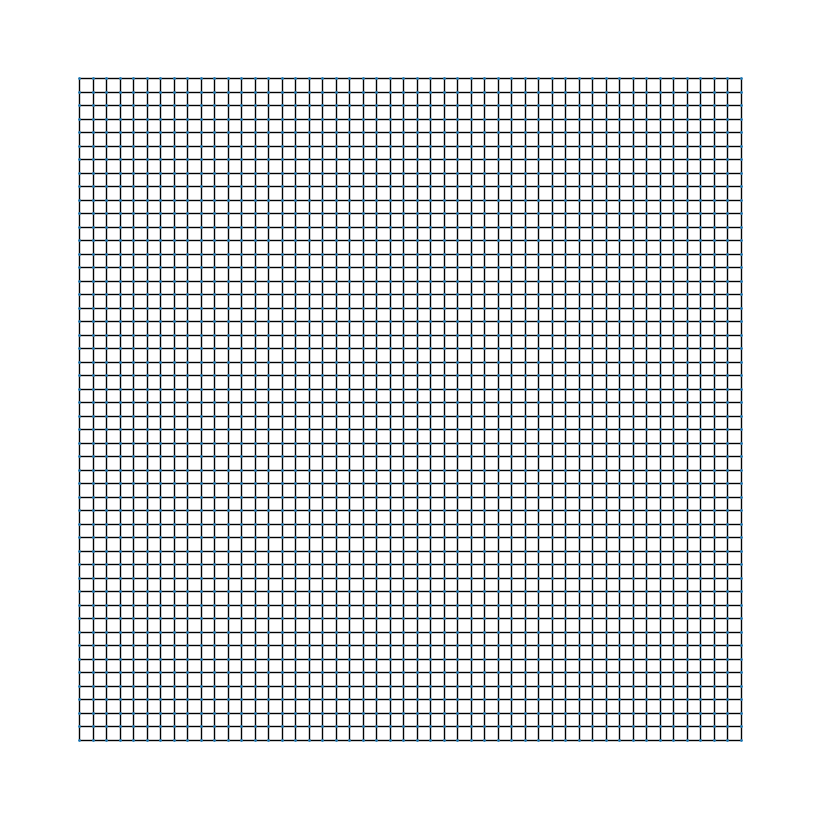

In [10]:
# Visualize the graph -- knowing 2-d structure
draw_2d_grid_graph(Graph_u, px, py, node_size=1)

In [11]:
U = np.zeros((n,p))
for i in range(n):
    U[i,:] = field[i].flatten()

# Compute responses

In [12]:
def h(U_i, j, a=1.0, b=5):
    return a * U_i[j] + b

In [13]:
m = min(px, py)  # Number of elements on the diagonal
Y = np.zeros((n, m))
a, b = 1.0, 5
for i in range(n):
    U_i = U[i, :]
    for k in range(m):
        j = k * (py + 1)  # Index for the diagonal element in the vectorized field
        Y[i, k] = h(U_i, j, a, b) + 0.1 * np.random.normal()

# Create observations -- we observe the diagonal in the 2D-field

In [14]:
d = np.repeat(8.0, m)

# Be specific about precision of noise
var_eps = 1.0
Prec_eps = sp.sparse.diags(
    [np.repeat(1/var_eps, m)], 
    offsets=[0],
    shape=(m, m), 
    format='csc'
)

# Ensemble information filter

In [15]:
# Create EnIF object
gtmap = EnIF(Graph_u = Graph_u, Prec_eps=Prec_eps)

In [16]:
# Fit both precision and sparse linear map H
gtmap.fit(U, Y, learning_algorithm="influence-boost", ordering_method="metis", verbose_level=5)
prior_prec_est = gtmap.Prec_u.copy()

/Users/BERL/Github/venv_sksparse/lib/python3.11/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


max degree of graph is: 4
Permutation optimization took 0.006396770477294922 seconds
Parameters in precision: 7400
Parameters in Cholesky factor: 36436
Starting statistical fitting of precision


Learning precision Cholesky factor row-by-row: 100%|██████████| 2500/2500 [00:01<00:00, 2442.18it/s]


Precision has log-determinant: 2267.48999229266
Learning sparse linear map of shape (50, 2500)


Learning sparse linear map for each response: 100%|██████████| 50/50 [00:20<00:00,  2.45it/s]

Total elements: 125000
Non-zero elements: 50
Fraction of non-zeros: 0.0004
Calculating unexplained variance


In [17]:
U_posterior = gtmap.transport(U, Y, d, verbose_level=5)

Mapping realizations to canonical space
Calculating unexplained variance
Calculating response residuals
Sampling with seed=None
Sampled Gaussian noise with shape (100, 50)
Total residual variance: 50.52501051744811
Unexplained variance: 0.5250105174481028
Measurement variance: 50.0
Mapping canonical-scaled realizations to moment realization


### Try incomplete Cholesky

In [18]:
from graphite_maps.precision_estimation import fit_precision_cholesky_approximate, optimize_sparse_affine_kr_map
from sklearn.preprocessing import StandardScaler

In [19]:
scaler_u = StandardScaler()
U_scaled = scaler_u.fit_transform(U)

In [20]:
Prec_u_approx_chol_incomplete = fit_precision_cholesky_approximate(
        U_scaled,
        Graph_u,
        neighbourhood_expansion = 1,
        verbose_level=4,
        use_tqdm=True,
    )

Starting statistical fitting of precision


Learning precision Cholesky factor row-by-row: 100%|██████████| 2500/2500 [00:00<00:00, 3765.49it/s]


In [21]:
gtmap_scale = EnIF(Prec_u = Prec_u_approx_chol_incomplete, Prec_eps=Prec_eps)
gtmap_scale.fit(U_scaled, Y, learning_algorithm="influence-boost", ordering_method="best", verbose_level=5)
U_posterior_scaled = gtmap_scale.transport(U_scaled, Y, d, verbose_level=5, iterative=True)
U_posterior_chol_incomplete = scaler_u.inverse_transform(U_posterior_scaled)

Precision u exists. Use `fit_precision` to refit if necessary
Learning sparse linear map of shape (50, 2500)


Learning sparse linear map for each response: 100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Total elements: 125000
Non-zero elements: 50
Fraction of non-zeros: 0.0004
Calculating unexplained variance
Mapping realizations to canonical space
Calculating unexplained variance
Calculating response residuals
Sampling with seed=None
Sampled Gaussian noise with shape (100, 50)
Total residual variance: 50.52501051744811
Unexplained variance: 0.5250105174481028
Measurement variance: 50.0
Mapping canonical-scaled realizations to moment realization


Mapping data to moment parametrisation realization-by-realization: 100%|██████████| 100/100 [00:00<00:00, 305.61it/s]


## Try expanded incomplete Cholesky

In [22]:
Prec_u_approx_chol_incomplete_epxanded = fit_precision_cholesky_approximate(
        U_scaled,
        Graph_u,
        neighbourhood_expansion = 3,
        verbose_level=4,
        use_tqdm=True,
    )

Starting statistical fitting of precision


Learning precision Cholesky factor row-by-row: 100%|██████████| 2500/2500 [00:01<00:00, 1873.44it/s]


In [23]:
gtmap_scale = EnIF(Prec_u = Prec_u_approx_chol_incomplete_epxanded, Prec_eps=Prec_eps)
gtmap_scale.fit(U_scaled, Y, learning_algorithm="influence-boost", ordering_method="best", verbose_level=5)
U_posterior_scaled = gtmap_scale.transport(U_scaled, Y, d, verbose_level=5, iterative=True)
U_posterior_chol_incomplete_expanded = scaler_u.inverse_transform(U_posterior_scaled)

Precision u exists. Use `fit_precision` to refit if necessary
Learning sparse linear map of shape (50, 2500)


Learning sparse linear map for each response: 100%|██████████| 50/50 [00:01<00:00, 28.61it/s]


Total elements: 125000
Non-zero elements: 50
Fraction of non-zeros: 0.0004
Calculating unexplained variance
Mapping realizations to canonical space
Calculating unexplained variance
Calculating response residuals
Sampling with seed=None
Sampled Gaussian noise with shape (100, 50)
Total residual variance: 50.52501051744811
Unexplained variance: 0.5250105174481028
Measurement variance: 50.0
Mapping canonical-scaled realizations to moment realization


Mapping data to moment parametrisation realization-by-realization: 100%|██████████| 100/100 [00:00<00:00, 113.81it/s]


## Reverse minmax ordering

In [24]:
import numpy as np
from heapdict import heapdict
from collections import defaultdict
import numba as nb
import time
from typing import Tuple, List, Dict, Set, Callable


# ---------------------------------------------------------------------
# 1.  Numba helpers (ℓ1 / “Manhattan’’ metric only)
# ---------------------------------------------------------------------
@nb.njit(inline='always')
def _manhattan(p: Tuple[float, float], q: Tuple[float, float]) -> float:
    """|x₁−x₂| + |y₁−y₂|  –  fast & in‑lined everywhere."""
    dx = p[0] - q[0]
    dy = p[1] - q[1]
    return abs(dx) + abs(dy)


@nb.njit
def _argsort_by_manhat(xk: Tuple[float, float],
                       idx: np.ndarray,
                       coords: np.ndarray) -> np.ndarray:
    """Return the indices `idx` sorted by ℓ1–distance to `xk`."""
    d = np.empty(len(idx), dtype=np.float64)
    for t, j in enumerate(idx):
        d[t] = _manhattan(xk, (coords[j, 0], coords[j, 1]))
    order = np.argsort(d)
    return idx[order]
# ---------------------------------------------------------------------


def reverse_maxmin_ordering(
    grid_points: np.ndarray,
    dist_to_boundary: np.ndarray,
    rho: float = 2.0,
    verbose: bool = False
) -> Tuple[List[int], Dict[int, Set[int]], float]:
    """
    Reverse max–min ordering and sparsity pattern based on the ℓ1 (Manhattan)
    metric.  Everything else – screening, pruning, truncation – is identical to
    your reference implementation.
    """
    N       = len(grid_points)
    coords  = grid_points.astype(np.float64, copy=False)

    # ------------------ state ----------------------------------------
    l              = dist_to_boundary.copy()
    selected       = np.zeros(N, dtype=np.bool_)
    not_selected   = set(range(N))
    ordering_idx   = []
    children       = defaultdict(list)
    parents        = defaultdict(list)
    children_sorted = np.zeros(N, dtype=np.bool_)

    heap = heapdict({i: -l_i for i, l_i in enumerate(l)})

    tic = time.perf_counter()

    # ------------------ first (seed) node ----------------------------
    i0, neg_li = heap.popitem()
    selected[i0]   = True
    not_selected.remove(i0)

    xi = (coords[i0, 0], coords[i0, 1])
    li = -neg_li
    ordering_idx.append(i0)

    # everybody is initially child of i0
    for j in range(N):
        parents[j].append(i0)
        children[i0].append(j)
        if j == i0:
            continue
        dij = _manhattan(xi, (coords[j, 0], coords[j, 1]))
        if dij < l[j]:
            l[j] = dij
            heap[j] = -dij

    l_trunc = li                      # current truncation radius

    # ------------------ main loop -----------------------------------
    while heap:
        i, neg_li = heap.popitem()
        if selected[i]:
            continue
        li = -neg_li
        xi = (coords[i, 0], coords[i, 1])
        selected[i] = True
        not_selected.remove(i)
        ordering_idx.append(i)

        # ---- choose parent k (Alg. C.1 lines 23‑32) ----------------
        k      = i0
        distik = np.inf
        for j in parents[i]:
            dij = _manhattan(xi, (coords[j, 0], coords[j, 1]))
            if (j == i0) or (dij + rho*li <= rho*min(l[j], l_trunc)):
                if dij < distik:
                    distik = dij
                    k = j

        xk = (coords[k, 0], coords[k, 1])

        # ---- ensure children[k] sorted once ------------------------
        # Slightly different form paper implementation
        # We sort children of k (once) only if the parent is selected as k
        if not children_sorted[k]:
            arr = np.asarray(children[k], dtype=np.int64)
            children[k] = _argsort_by_manhat(xk, arr, coords).tolist()
            children_sorted[k] = True

        r_li = rho * li                # only once
        for j in children[k]:
            if j == i:
                continue
            djk = _manhattan((coords[j, 0], coords[j, 1]), xk)
            if djk > distik + r_li:    # triangle‑ineq pruning
                break

            dij = _manhattan(xi, (coords[j, 0], coords[j, 1]))

            if (not selected[j]) and dij < l[j]:
                l[j]   = dij
                heap[j] = -dij

            if dij <= r_li:
                children[i].append(j)
                parents[j].append(i)

        # ---- truncation test (Alg. C.1 lines 43‑49) ----------------
        # This ensures linear space complexity
        # Modification of reference algorithm Schäfer 2020 Algorithm 4.1
        cond = True
        half_ltr = 0.5 * l_trunc
        for j in not_selected:
            if _manhattan(xi, (coords[j, 0], coords[j, 1])) >= half_ltr:
                cond = False
                break

        if cond:
            l_trunc *= 0.5
            rho_ltr = rho * l_trunc
            keep = []
            for j in children[i]:
                if (j not in not_selected) or \
                   (_manhattan(xi, (coords[j, 0], coords[j, 1])) <= rho_ltr):
                    keep.append(j)
                else:                  # prune long edge
                    parents[j].remove(i)
            children[i] = keep

    # --------------- build sparsity sets ----------------------------
    sparsity = defaultdict(set)
    for i, kids in children.items():
        sparsity[i].update(kids)
        sparsity[i].add(i)

    toc = time.perf_counter()
    return ordering_idx, sparsity, toc - tic

In [25]:
def create_grid_points(p: int) -> np.ndarray:
    """
    Creates a list of (i, j) integer coordinates for a p x p grid.

    Parameters
    ----------
    p : int
        Size of the grid (number of interior points in each dimension)

    Returns
    -------
    np.ndarray
        Array of shape (N, 2) with all (i, j) grid coordinates.
    """
    grid = np.array([(i, j) for i in range(p) for j in range(p)], dtype=int)
    return grid

# Define the boundary points (∂Ω) on the conceptual (p+1)x(p+1) grid
def create_boundary_points(p: int) -> List[Tuple[int, int]]:
    """
    Returns the set of points on the boundary of a (p+1)x(p+1) grid
    that are adjacent to the interior p x p grid.

    These are all points with at least one coordinate equal to -1 or p.
    """
    boundary = []
    for i in range(-1, p + 1):
        boundary.append((i, -1))
        boundary.append((i, p))
    for j in range(0, p):
        boundary.append((-1, j))
        boundary.append((p, j))
    return boundary

def compute_distance_to_boundary(
    interior_points: np.ndarray,
    boundary_points: List[Tuple[int, int]],
    distance_fn: Callable[[Tuple[int, int], Tuple[int, int]], int]
) -> np.ndarray:
    """
    Computes the minimum distance from each interior grid point to the boundary.

    Parameters
    ----------
    interior_points : np.ndarray
        Array of shape (N, 2) containing grid coordinates of interior points.
    boundary_points : list of tuple
        List of boundary coordinates.
    distance_fn : callable
        A function that computes distance between two points.

    Returns
    -------
    np.ndarray
        Array of shape (N,) where each entry is the distance from an interior point
        to the closest boundary point.
    """
    distances = np.array([
        min(distance_fn(tuple(p), b) for b in boundary_points)
        for p in interior_points
    ])
    return distances

In [26]:
# 1. Create grid and data
p = px # px or py, assumes square
grid_points = create_grid_points(p)

# Step 2: Create the geometric boundary for a pxp
boundary_points = create_boundary_points(p)

# Step 3: Compute distance to boundary for each interior point
dist_to_boundary = compute_distance_to_boundary(
    grid_points,
    boundary_points,
    _manhattan,
)

In [27]:
ordering_revmaxmin, sparsity, wall = reverse_maxmin_ordering(
        grid_points        = grid_points,               # (N,2) float64
        dist_to_boundary   = dist_to_boundary,               # (N,)
        rho                = 2.0,
        verbose            = False
)

print(f"finished in {wall:.3f} s,  ordering length={len(ordering_revmaxmin)}")

finished in 1.196 s,  ordering length=2500


In [28]:
# The ordering_revmaxmin is in fact the actual ordering for KR map (rev-transpose chol)a
# Create graph for KR
def kr_graph(sparsity: dict, ordering_revmaxmin_chol: list):
    reverse_ordering = {value: ind for ind, value in enumerate(ordering_revmaxmin_chol)}
    Graph_kr = nx.DiGraph()
    for row in sparsity:
        for col in sparsity[row]:
            row_idx = reverse_ordering[row]
            col_idx = reverse_ordering[col]
            if row_idx >= col_idx: # only lower triangle
                Graph_kr.add_edge(row_idx, col_idx)
    return Graph_kr

Graph_revmaxmin = kr_graph(sparsity, ordering_revmaxmin)

In [29]:
def fit_precision_revmaxmin(
    U: np.ndarray,
    sparsity: dict, 
    ordering_revmaxmin_chol: list,
    verbose_level: int = 0,
    use_tqdm=True,
) -> sp.sparse.csc_matrix:

    # Fetch graph for KR map using revmaxmin intended for chol and associate sparsity
    Graph_revmaxmin = kr_graph(sparsity, ordering_revmaxmin_chol)

    # Reorder U: rev-revmaxmin = maxmin
    U_reordered = U[:, ordering_revmaxmin_chol]

    # Estimate KR map from data
    C = optimize_sparse_affine_kr_map(
        U_reordered,
        Graph_revmaxmin,
        verbose_level=verbose_level - 1,
        use_tqdm=use_tqdm,
    )
    Prec_approx = C.T @ C

    # Permute back to before any ordering
    Perm = sp.sparse.eye(Prec_approx.shape[0], format="csc")[ordering_revmaxmin_chol, :]
    Prec_original = Perm.T @ Prec_approx @ Perm
    
    return Prec_original

In [30]:
Prec_revmaxmin = fit_precision_revmaxmin(
    U_scaled,
    sparsity,
    ordering_revmaxmin,
    verbose_level=4
)

Starting statistical fitting of precision


Learning precision Cholesky factor row-by-row: 100%|██████████| 2500/2500 [00:01<00:00, 2487.10it/s]


In [31]:
gtmap_revmaxmin = EnIF(Prec_u = Prec_revmaxmin, Prec_eps=Prec_eps)
gtmap_revmaxmin.fit(U_scaled, Y, learning_algorithm="influence-boost", ordering_method="best", verbose_level=5)
U_posterior_scaled = gtmap_revmaxmin.transport(U_scaled, Y, d, verbose_level=5, iterative=True)

Precision u exists. Use `fit_precision` to refit if necessary
Learning sparse linear map of shape (50, 2500)


Learning sparse linear map for each response: 100%|██████████| 50/50 [00:01<00:00, 30.83it/s]


Total elements: 125000
Non-zero elements: 50
Fraction of non-zeros: 0.0004
Calculating unexplained variance
Mapping realizations to canonical space
Calculating unexplained variance
Calculating response residuals
Sampling with seed=None
Sampled Gaussian noise with shape (100, 50)
Total residual variance: 50.52501051744811
Unexplained variance: 0.5250105174481028
Measurement variance: 50.0
Mapping canonical-scaled realizations to moment realization


Mapping data to moment parametrisation realization-by-realization: 100%|██████████| 100/100 [00:00<00:00, 156.90it/s]


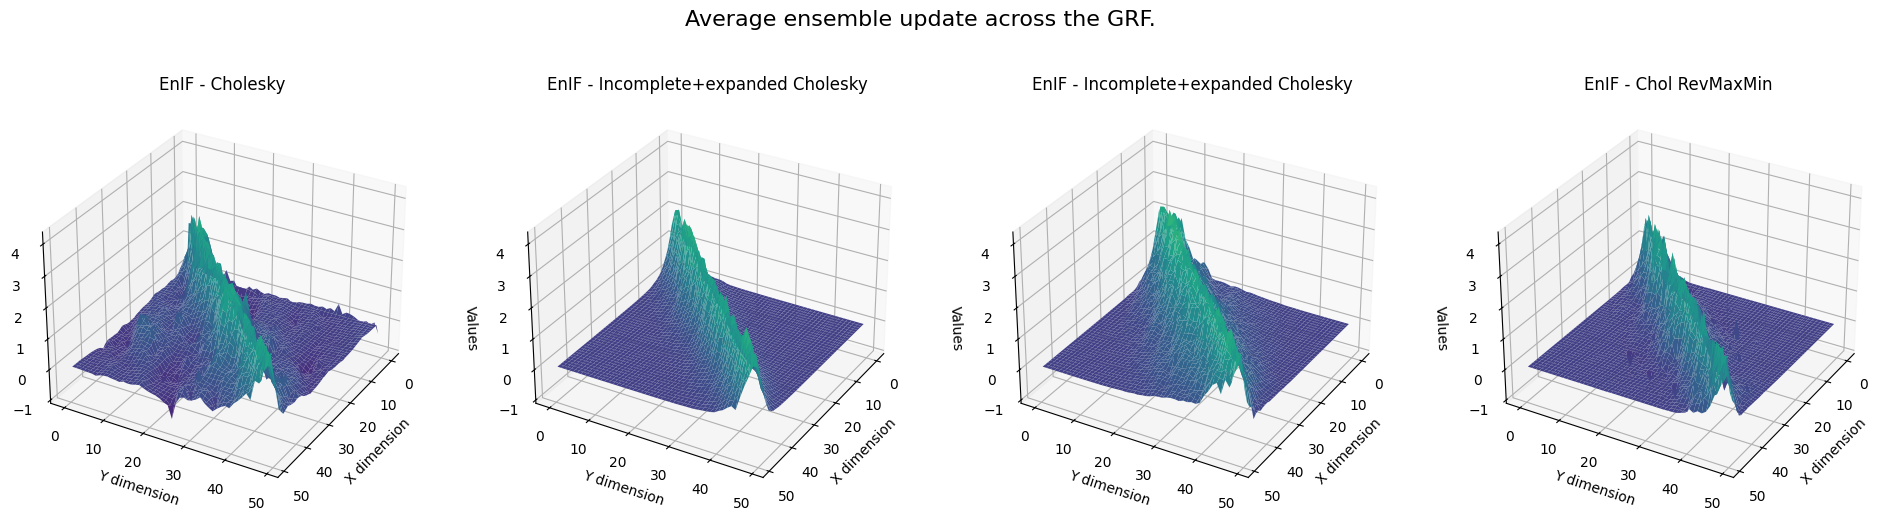

In [32]:
U_posterior_revmaxmin = scaler_u.inverse_transform(U_posterior_scaled)
plot_fields_3d(
    [ np.mean(U_posterior-U, axis=0),
     np.mean(U_posterior_chol_incomplete-U, axis=0),
     np.mean(U_posterior_chol_incomplete_expanded - U, axis=0),
    np.mean(U_posterior_revmaxmin-U, axis=0),
    ],
    px, py, 
    vmin=-1, vmax=vmax, 
    titles=['EnIF - Cholesky', "EnIF - Incomplete+expanded Cholesky", "EnIF - Incomplete+expanded Cholesky", "EnIF - Chol RevMaxMin"], 
    overall_title=f"Average ensemble update across the GRF.",
    #file_name = f"update_mean_size_{px}x{py}"
)

### Visualize ordering on grid

In [33]:
def visualize_ordering_on_grid(ordering, shape, title="Elimination Order on Grid"):
    """
    Visualizes the elimination order on the 2D grid as a heatmap.
    """
    rows, cols = shape
    order_matrix = np.full((rows, cols), np.nan)
    for rank, (i, j) in enumerate(ordering):
        order_matrix[i, j] = rank

    plt.figure(figsize=(6, 6))
    plt.imshow(order_matrix, cmap='viridis', origin='upper')
    plt.colorbar(label='Elimination Order')
    plt.title(title)
    plt.axis('off')
    plt.show()

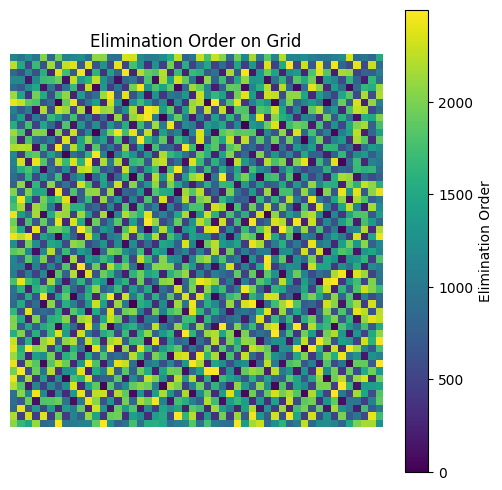

In [34]:
visualize_ordering_on_grid(grid_points[ordering_revmaxmin], (px, py))

## Testing graphite-maps implementation

In [40]:
from graphite_maps.cholesky_estimation.reverse_maximin import reverse_maxmin_ordering as reverse_maxmin_package

from time import time

In [41]:

tic = time()
ordering_revmaxmin, sparsity = reverse_maxmin_package(
        grid_points        = grid_points,               # (N,2) float64
        dist_to_boundary   = dist_to_boundary,               # (N,)
        rho                = 2.0,
        verbose            = False
)
toc = time()
wall = toc - tic

print(f"finished in {wall:.3f} s,  ordering length={len(ordering_revmaxmin)}")

finished in 0.586 s,  ordering length=2500


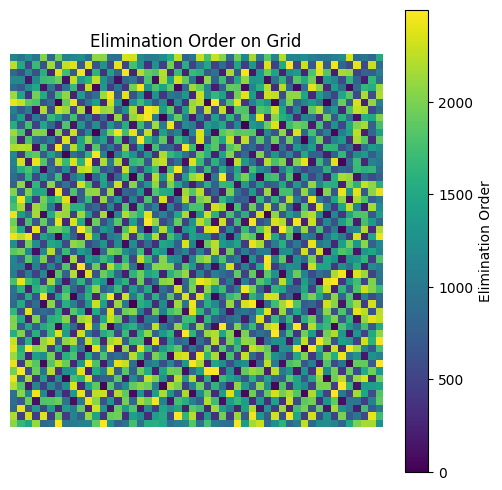

In [42]:
visualize_ordering_on_grid(grid_points[ordering_revmaxmin], (px, py))